<a href="https://colab.research.google.com/github/zw2497/Neural_Network_PDE/blob/master/ODE2_Mid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip -q install tf-nightly-2.0-preview

In [0]:
import tensorflow as tf 
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
import time
%matplotlib inline

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.nn import relu

In [15]:
print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required

You have version 2.0.0-dev20190427


# Build Function

In [0]:
def f(x):
    '''
        d2(psy)/dx2 = f(x, dpsy/dx, psy)
        This is f() function on the right
    '''
    return tf.math.sin(x) + tf.math.sin(4*x) / 4 + tf.math.sin(8*x) / 8 + tf.math.sin(24*x) / 36

def psy_trial(xi, net_out):
    return (tf.constant(-1, dtype='float32') - xi) * (tf.constant(1,dtype='float32') - xi) * net_out

# Build Neural Network

In [0]:
model = Sequential()
model.add(Dense(64, input_shape=(None, 1), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1,  activation='tanh'))
optimizer = tf.keras.optimizers.Adam()

# Prepare Dataset

In [0]:
nx = 100
x_space = np.linspace(-1, 1, nx).astype('float32').reshape(nx,1)
x_space = tf.constant(x_space)
batch_size = 10
dataset = tf.data.Dataset.from_tensor_slices(x_space).batch(batch_size, drop_remainder=True)

# Train

In [0]:
def loss_function(y_true, y_pred):
    return tf.reduce_sum(keras.losses.mean_squared_error(y_true, y_pred),0)

In [0]:
def train_on_batch(x):
    with tf.GradientTape() as g_total:
        g_total.watch(model.variables)
        with tf.GradientTape() as g:
            g.watch(x)
            with tf.GradientTape() as gg:
                gg.watch(x)
                net_out = model(x)
                psy_t = psy_trial(x, net_out)

            dy_dx = gg.gradient(psy_t, x)     # gradient
        d2y_dx2 = g.gradient(dy_dx, x)  # second order gradient
        func = f(x) # right part function
        loss = loss_function(d2y_dx2, func)

    grads = g_total.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return tf.math.reduce_sum(loss)

In [21]:
for epoch in range(40):
    for batch, source_data in enumerate(dataset):
        start = time.time()
        loss = train_on_batch(source_data)
    print("Epoch #%d, Loss %.4f, Time %.2f sec" % (epoch, loss, time.time() - start))


Epoch #0, Loss 0.8575, Time 0.01 sec
Epoch #1, Loss 2.8482, Time 0.01 sec
Epoch #2, Loss 0.9895, Time 0.01 sec
Epoch #3, Loss 0.0388, Time 0.01 sec
Epoch #4, Loss 0.0316, Time 0.01 sec
Epoch #5, Loss 0.2132, Time 0.01 sec
Epoch #6, Loss 0.2417, Time 0.01 sec
Epoch #7, Loss 0.1137, Time 0.01 sec
Epoch #8, Loss 0.0913, Time 0.01 sec
Epoch #9, Loss 0.1090, Time 0.01 sec
Epoch #10, Loss 0.0938, Time 0.01 sec
Epoch #11, Loss 0.0707, Time 0.01 sec
Epoch #12, Loss 0.0605, Time 0.01 sec
Epoch #13, Loss 0.0530, Time 0.01 sec
Epoch #14, Loss 0.0421, Time 0.01 sec
Epoch #15, Loss 0.0343, Time 0.01 sec
Epoch #16, Loss 0.0329, Time 0.01 sec
Epoch #17, Loss 0.0256, Time 0.01 sec
Epoch #18, Loss 0.0226, Time 0.01 sec
Epoch #19, Loss 0.0209, Time 0.01 sec
Epoch #20, Loss 0.0180, Time 0.01 sec
Epoch #21, Loss 0.0159, Time 0.01 sec
Epoch #22, Loss 0.0157, Time 0.01 sec
Epoch #23, Loss 0.0162, Time 0.01 sec
Epoch #24, Loss 0.0179, Time 0.01 sec
Epoch #25, Loss 0.0164, Time 0.01 sec
Epoch #26, Loss 0.0158

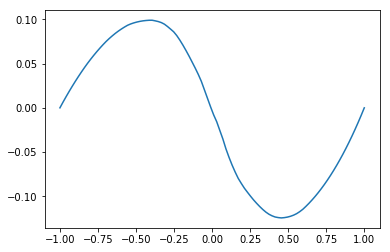

In [22]:
plt.figure()
res = psy_trial(x_space, model(x_space)).numpy().reshape(nx)
plt.plot(x_space, res)
plt.show()